### Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
*   для топ 10%
*   всего тестового набора данных (summary_plot - дать интерпретацию)
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### Набор данных для прогнозирования риска диабета на ранней стадии

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [7]:
TRAIN_DATASET_PATH = './diabetes_data_upload.csv'

### Загрузка данных

In [8]:
data = pd.read_csv(TRAIN_DATASET_PATH)

### Изучение датасета

In [9]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [11]:
features = data.columns.drop(['Age', 'Gender', 'class'])
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})
data['class'] = data['class'].replace({'Positive': 1, 'Negative': 0})
for i in features:
    data[i] = data[i].replace({'Yes': 1, 'No': 0})

In [12]:
data.tail()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0
519,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Анализ целевой переменной

In [13]:
data['class'].value_counts()

1    320
0    200
Name: class, dtype: int64

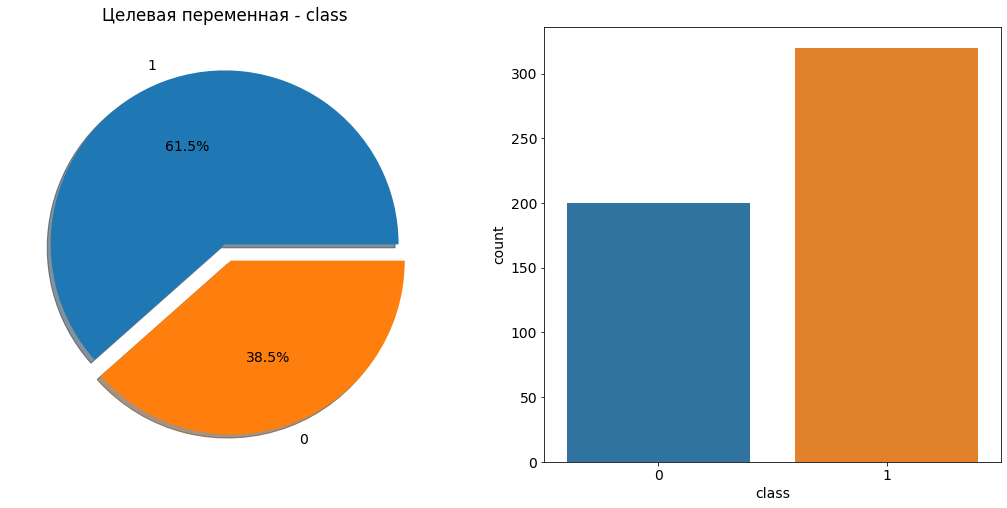

In [14]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
data['class'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Целевая переменная - class')
ax[0].set_ylabel('')
sns.countplot('class', data=data, ax=ax[1])
plt.show()

### Обработка выбросов и пропусков

In [15]:
data.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### Корреляция признаков

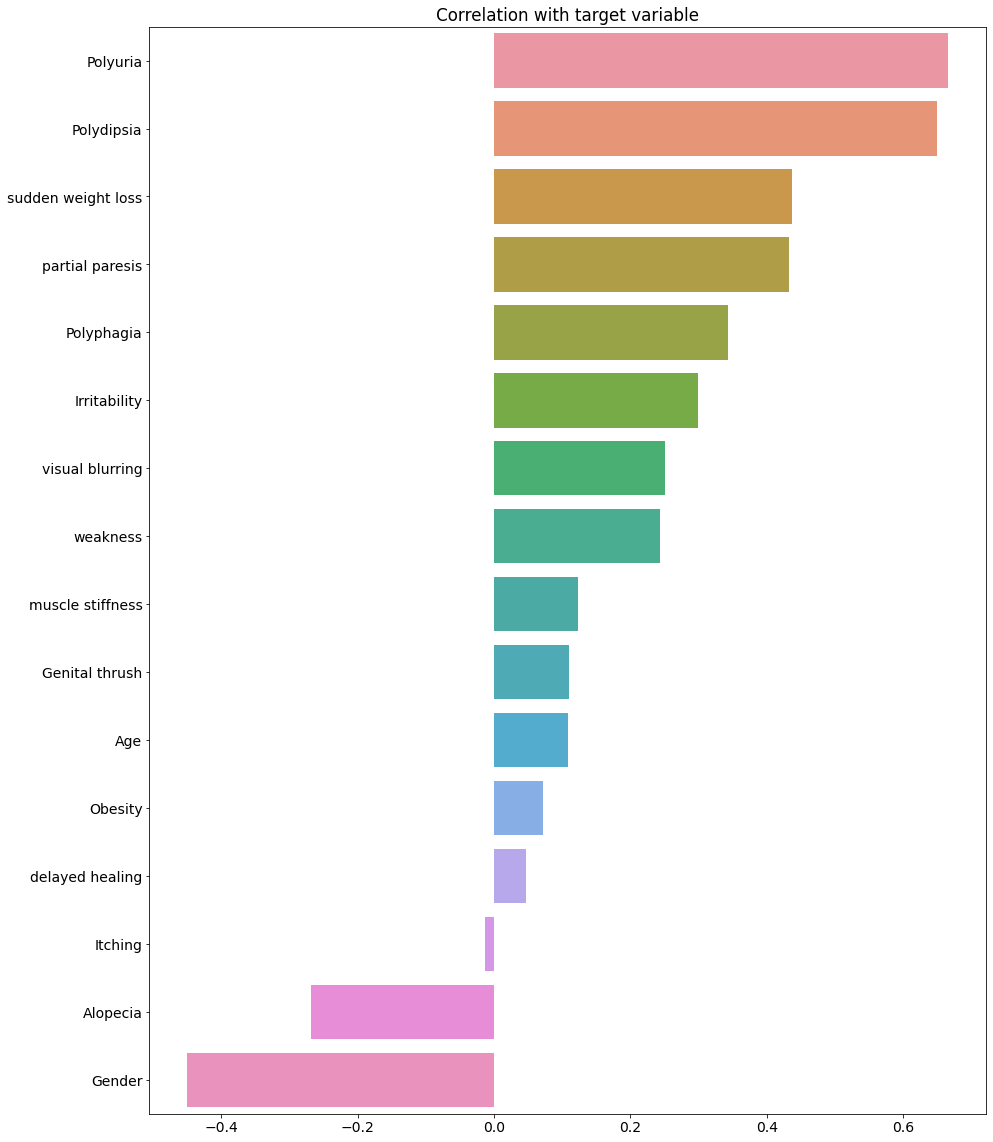

In [16]:
TARGET_NAME = 'class'

corr_with_target = data.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

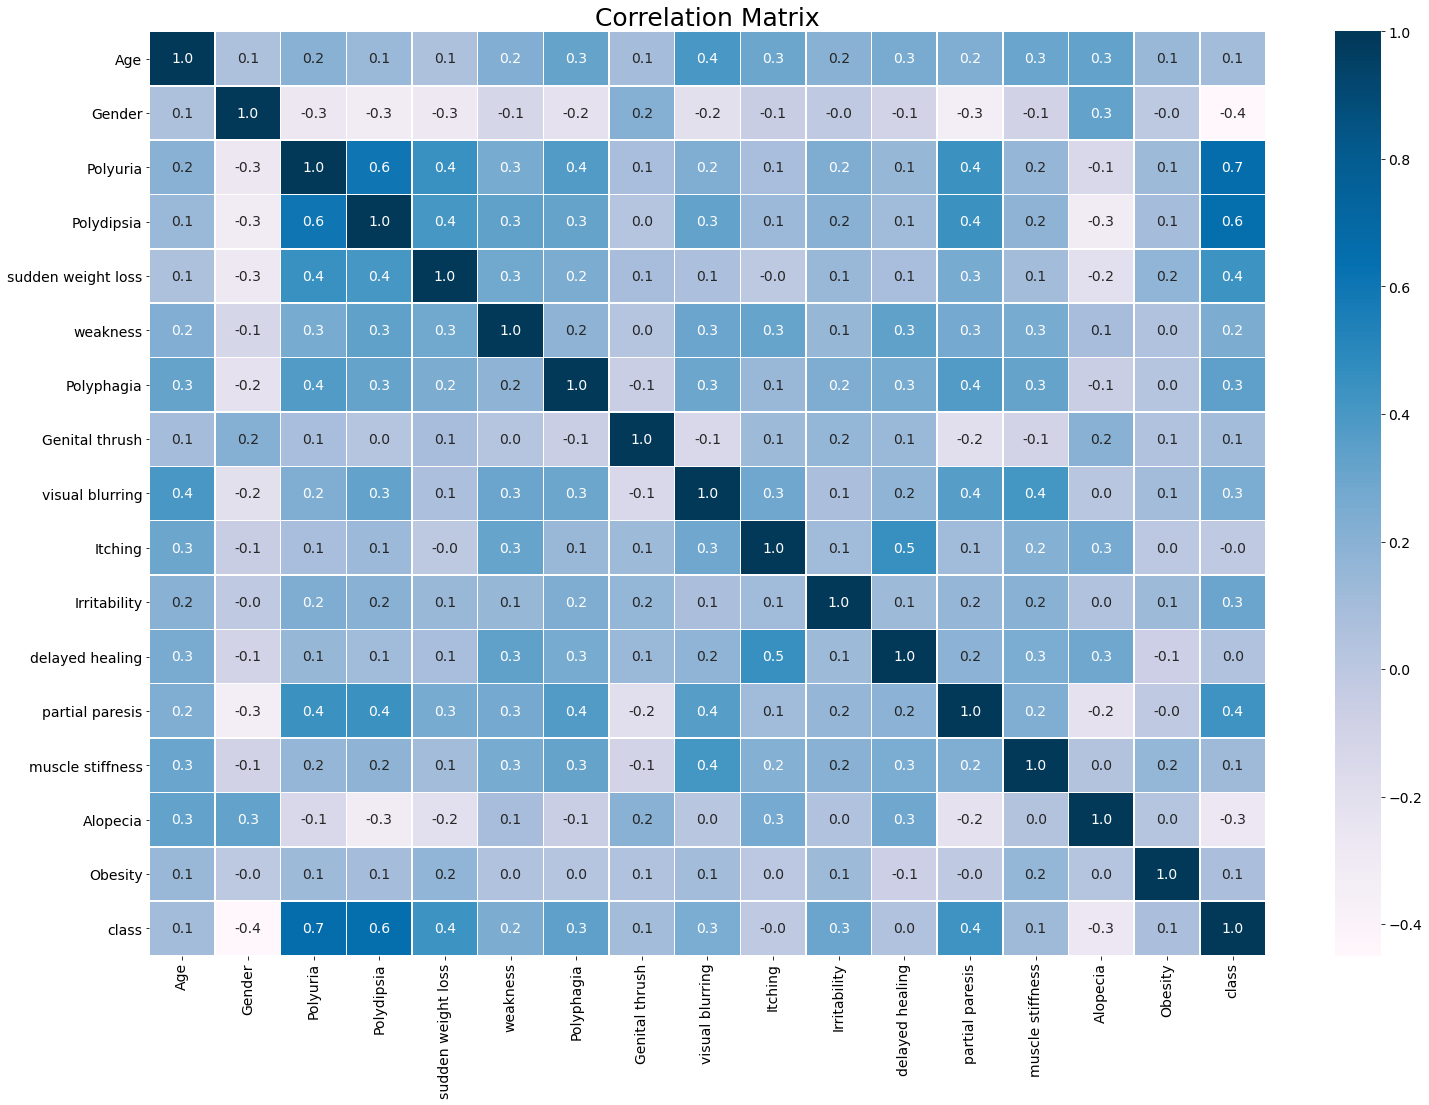

In [17]:
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

In [18]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('class', 1), data['class'], 
                                                    test_size=0.30, 
                                                    random_state=0)

In [20]:
continuous_cols = ['Age']
base_cols = data.columns.drop(['Age', 'class'])

In [21]:
continuos_transformers = []
base_transformers = []


for cont_col in continuous_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [22]:
feats = FeatureUnion(continuos_transformers+base_transformers)

feature_processing = Pipeline([('feats', feats)])
df_transform = feature_processing.fit_transform(data)

### Подбор классификаторов

In [23]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('XGBClassifier', XGBClassifier(silent=True)))
models.append(('SVM', SVC(gamma='auto')))

In [24]:
results = []

for name, model in models:
    pipeline = Pipeline([
    ('features',feats),
    (name, model),
])
    pipeline.fit(X_train, y_train)
    y_pred_train  = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
1,ExtraTreesClassifier,1.00000,0.98413,0.98077
0,CatBoostClassifier,1.00000,0.98396,0.98077
3,LGBMClassifier,1.00000,0.98396,0.98077
4,RandomForestClassifier,1.00000,0.98396,0.98077
5,XGBClassifier,1.00000,0.98396,0.98077
2,GradientBoostingClassifier,1.00000,0.97872,0.97436
6,SVM,0.94570,0.94624,0.93590


### Алгоритм - LGBMClassifier

In [25]:
%%time
pipeline_lgbm = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier()),
])
pipeline_lgbm.fit(X_train, y_train)
y_pred_train = pipeline_lgbm.predict(X_train)
y_pred_test = pipeline_lgbm.predict(X_test)
print('TRAIN - CatBoostClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - CatBoostClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       226

    accuracy                           1.00       364
   macro avg       1.00      1.00      1.00       364
weighted avg       1.00      1.00      1.00       364

TEST - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        62
           1       0.99      0.98      0.98        94

    accuracy                           0.98       156
   macro avg       0.98      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156

TRAIN - CatBoostClassifier - 1.0
TEST - CatBoostClassifier - 0.983957219251337
Wall time: 147 ms


### Алгоритм - CatBoostClassifier

In [26]:
%%time
pipeline_cat = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True)),
])
pipeline_cat.fit(X_train, y_train)
y_pred_train = pipeline_cat.predict(X_train)
y_pred_test = pipeline_cat.predict(X_test)
print('TRAIN - CatBoostClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - CatBoostClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - CatBoostClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - CatBoostClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - CatBoostClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       226

    accuracy                           1.00       364
   macro avg       1.00      1.00      1.00       364
weighted avg       1.00      1.00      1.00       364

TEST - CatBoostClassifier

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        62
           1       0.99      0.98      0.98        94

    accuracy                           0.98       156
   macro avg       0.98      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156

TRAIN - CatBoostClassifier - 1.0
TEST - CatBoostClassifier - 0.983957219251337
Wall time: 2.35 s


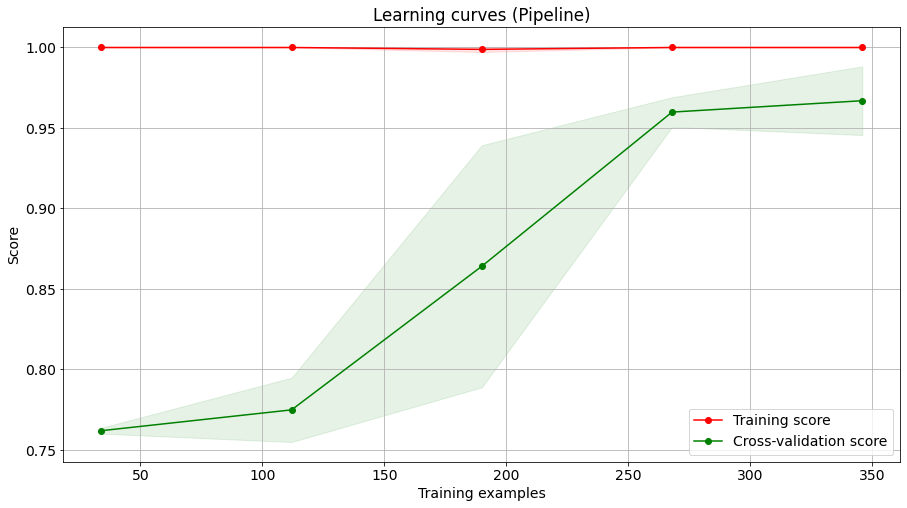

In [27]:
show_learning_curve_plot(pipeline_lgbm, data.drop('class', 1), data['class'])

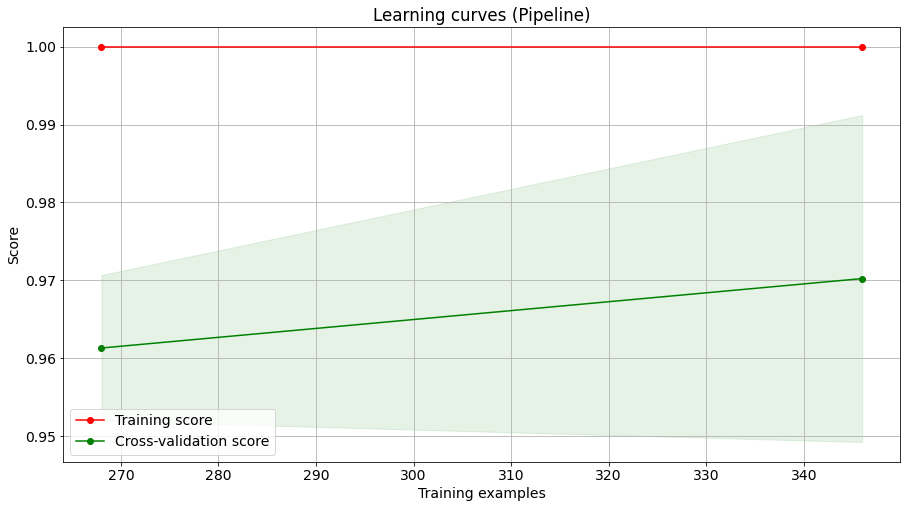

In [29]:
show_learning_curve_plot(pipeline_cat, data.drop('class', 1), data['class'])

Confusion matrix, without normalization
[[61  1]
 [ 2 92]]


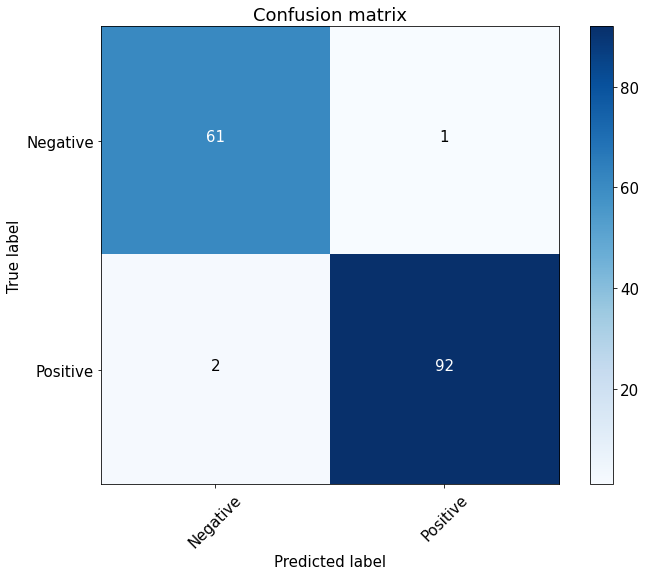

In [30]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

### SHAP

In [31]:
import shap

In [42]:
shap.initjs()

explainer = shap.KernelExplainer(pipeline_lgbm.named_steps['classifier'].predict, X_test)
#explainer = shap.TreeExplainer(pipeline_lgbm)
shap_values = explainer.shap_values(X_test)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/156 [00:00<?, ?it/s]

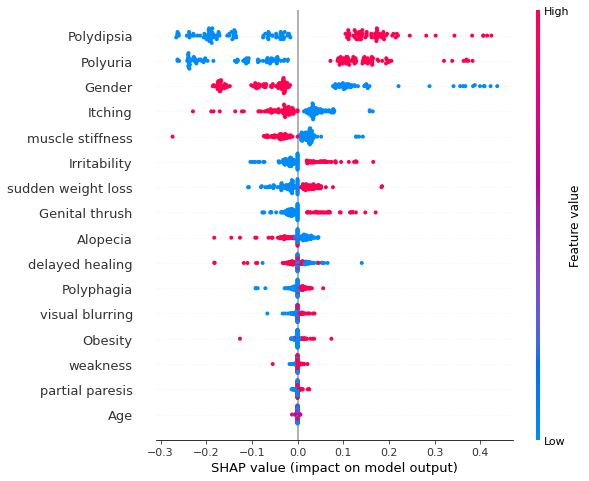

In [43]:
shap.summary_plot(shap_values, X_test)

In [49]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

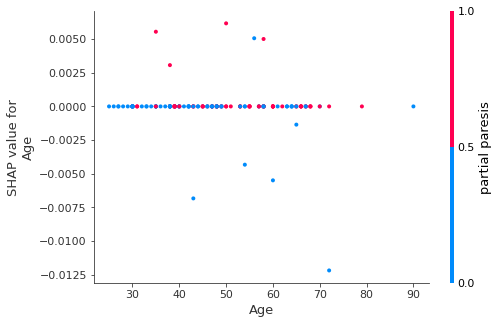

In [50]:
shap.dependence_plot('Age', shap_values, X_test)

In [51]:
shap.initjs()

explainer = shap.KernelExplainer(pipeline_cat.named_steps['classifier'].predict, X_test)
#explainer = shap.TreeExplainer(pipeline_lgbm)
shap_values = explainer.shap_values(X_test)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/156 [00:00<?, ?it/s]

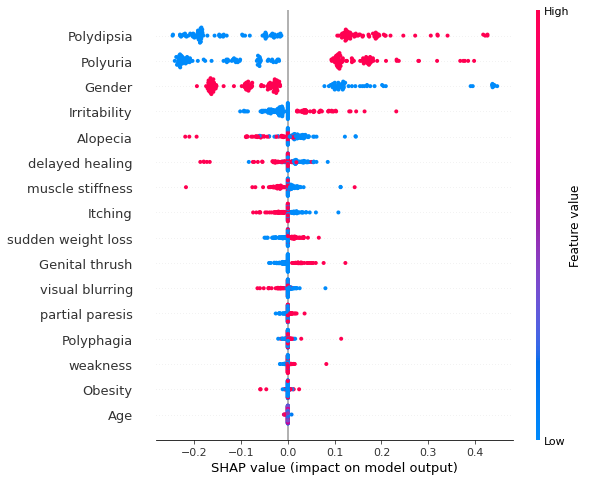

In [52]:
shap.summary_plot(shap_values, X_test)

In [53]:
shap.force_plot(explainer.expected_value, shap_values[43,:], X_test.iloc[43,:])

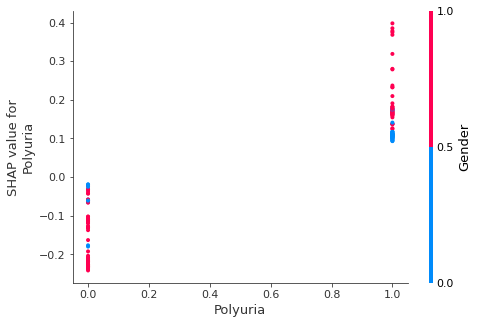

In [54]:
shap.dependence_plot('Polyuria', shap_values, X_test)

Т.к. датасет представляет собой некую анкету для пациентов(да или нет) и отсутствуют объективные непрерывные величины, то данный датасет не выдает нам полную картину этого наблюдения. Но тем не менее, из вышеприведённых графиков, созданных с помощью инструмента SHAP, можно сделать интересные выводы:
* при выявлении у пациента признаков Polydipsia(сильная, неутолимая жаждой), Polyuria(увеличенное образование мочи) и Irritability(раздражительность), растет вероятность подтверждения у него диабета.
* ожирение, слабость, сильный голод и другие факторы отчетливо показывают на графике force_plot для отдельного пациента их "вклад" в развитие диабета
* примечатлен тот факт, что в данном датасете, мужская половина населения этой локальной местности менее подвержена к диабету. 